![課題_スクリーンショット](../img/課題.png)

## モデリングA

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('../data/apparel_clean.csv')
df.head()

,ds,Weather,Bargain,y,Closed,Holiday
0,1990-01-05,0.0,0.0,58507.0,0,0
1,1990-01-06,0.0,0.0,49088.0,0,0
2,1990-01-07,0.0,0.0,50066.0,0,0
3,1990-01-08,0.0,0.0,45954.0,0,0
4,1990-01-09,0.0,0.0,66422.0,0,0


In [3]:
df['ds'] = pd.to_datetime(df['ds'])
df["y"] = np.log(df["y"]).replace([0, np.inf, -np.inf], np.nan)
train = df[df['ds'] <= '1992-12-31']
test = df[df['ds'] > '1992-12-31']

print('train shape:', train.shape)
print('test shape:', test.shape)

train_y = train['y']
test_y = test['y']
train_X = train.drop(columns=['y'])
test_X = test.drop(columns=['y'])

train shape: (1092, 6)
test shape: (365, 6)


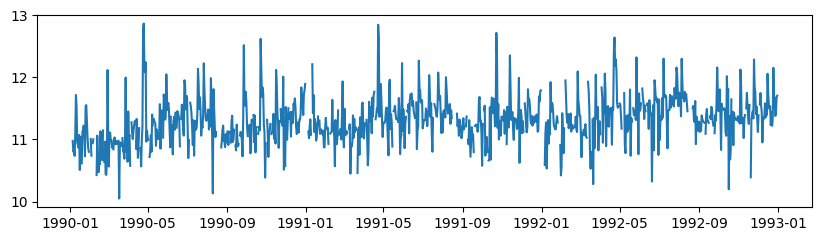

In [4]:
plt.figure(figsize=(10,2.5),dpi=100)
plt.plot(pd.to_datetime(train_X["ds"]), train_y)
plt.show()

In [5]:
train

,ds,Weather,Bargain,y,Closed,Holiday
0,1990-01-05,0.0,0.0,10.976902,0,0
1,1990-01-06,0.0,0.0,10.801370,0,0
2,1990-01-07,0.0,0.0,10.821097,0,0
3,1990-01-08,0.0,0.0,10.735396,0,0
4,1990-01-09,0.0,0.0,11.103784,0,0
...,...,...,...,...,...,...
1087,1992-12-27,0.0,1.0,11.660069,0,0
1088,1992-12-28,0.0,1.0,11.378525,0,0
1089,1992-12-29,0.0,0.0,11.425623,0,0
1090,1992-12-30,0.0,0.0,11.675911,0,0


## 長期的なトレンド予測

23:59:22 - cmdstanpy - INFO - Chain [1] start processing
23:59:23 - cmdstanpy - INFO - Chain [1] done processing


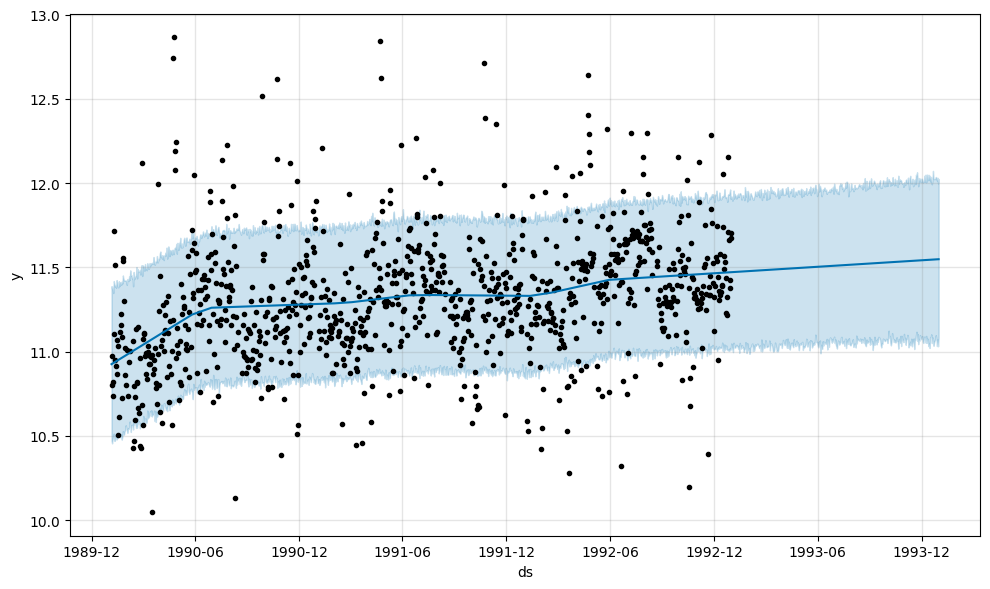

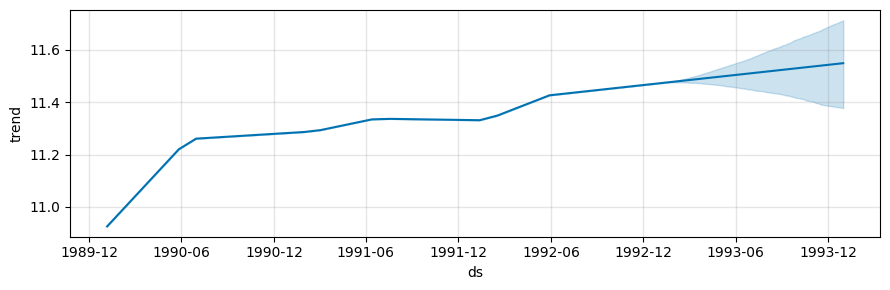

In [8]:
m = Prophet(weekly_seasonality = False, yearly_seasonality = False)
m.fit(train)

#予測する日付を生成
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

In [15]:
# 祝日
h_holiday = train.loc[train['Holiday'] == 1, ['ds']].copy()
h_holiday['holiday'] = 'holiday'
h_holiday['lower_window'] = 0
h_holiday['upper_window'] = 0

# バーゲン
h_bargain = train.loc[train['Bargain'] == 1, ['ds']].copy()
h_bargain['holiday'] = 'bargain'
h_bargain['lower_window'] = 0
h_bargain['upper_window'] = 0

# 休業日
h_closed = train.loc[train['Closed'] == 1, ['ds']].copy()
h_closed['holiday'] = 'closed'
h_closed['lower_window'] = 0
h_closed['upper_window'] = 0

holidays = pd.concat([h_holiday, h_bargain, h_closed], ignore_index=True)
holidays = holidays[['holiday', 'ds', 'lower_window', 'upper_window']]

00:14:08 - cmdstanpy - INFO - Chain [1] start processing
00:14:08 - cmdstanpy - INFO - Chain [1] done processing


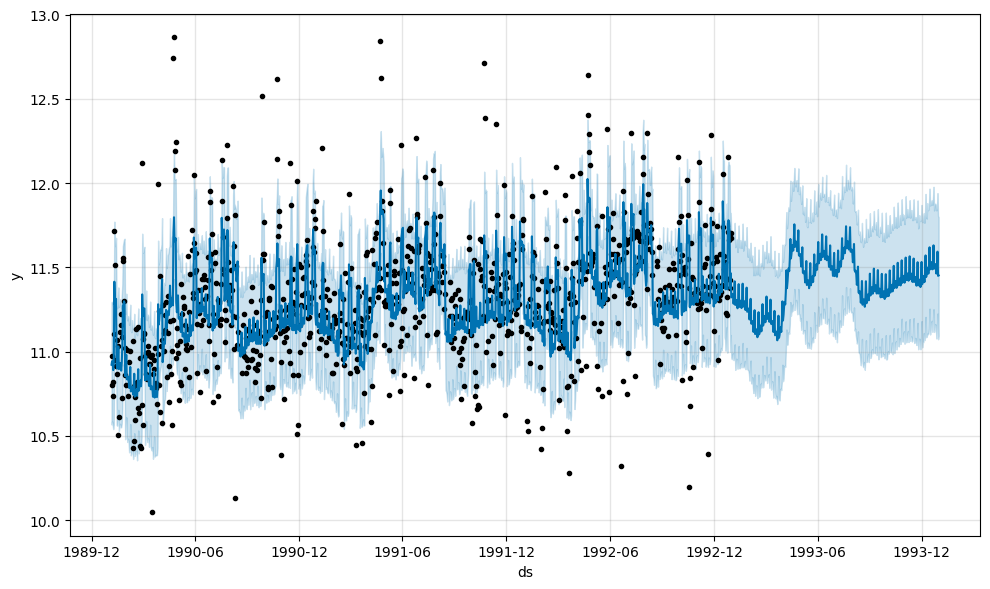

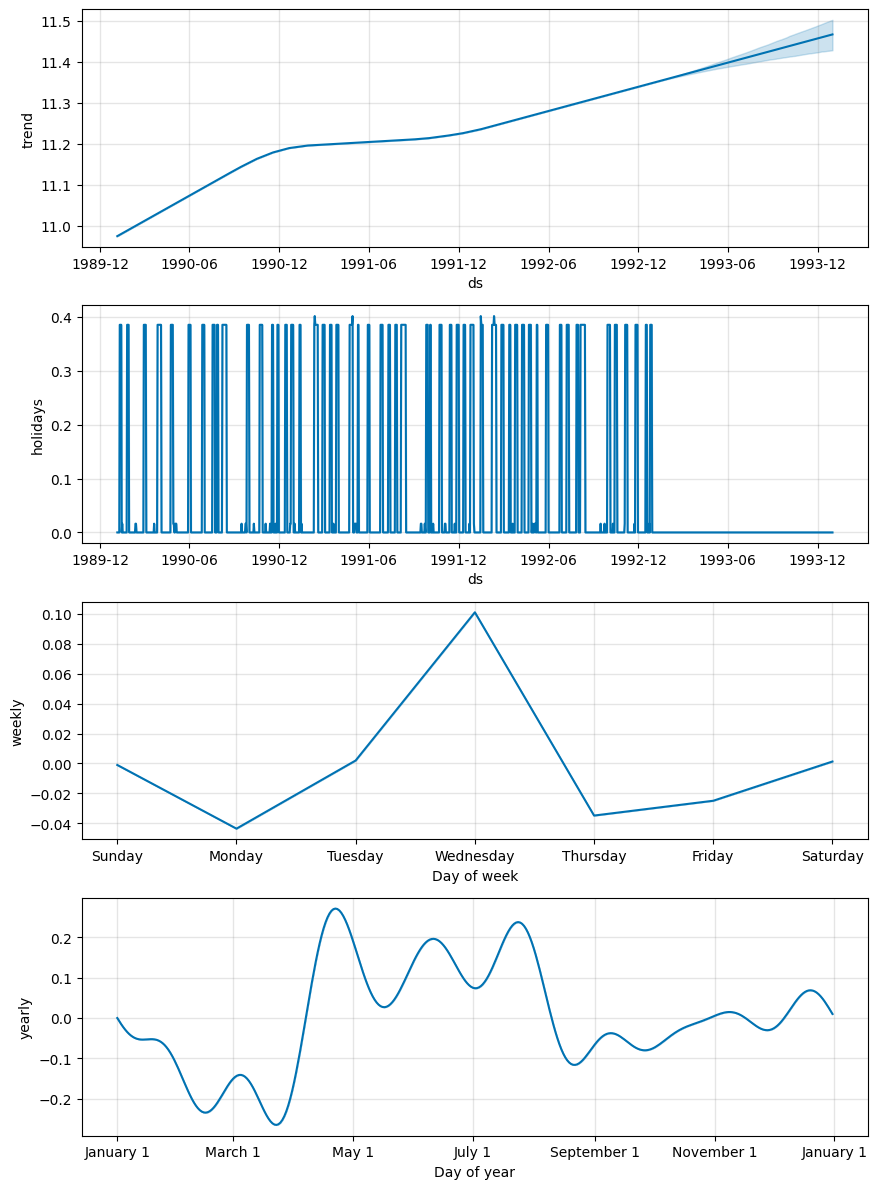

In [16]:
m = Prophet(weekly_seasonality = True, yearly_seasonality = True, holidays= holidays)
m.fit(train)

#予測する日付を生成
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

## テスト予測

,ds,yhat,yhat_lower,yhat_upper
0,1993-01-01,11.324261,10.957322,11.708992
1,1993-01-02,11.342936,10.971900,11.702604
2,1993-01-03,11.333460,10.962340,11.700094


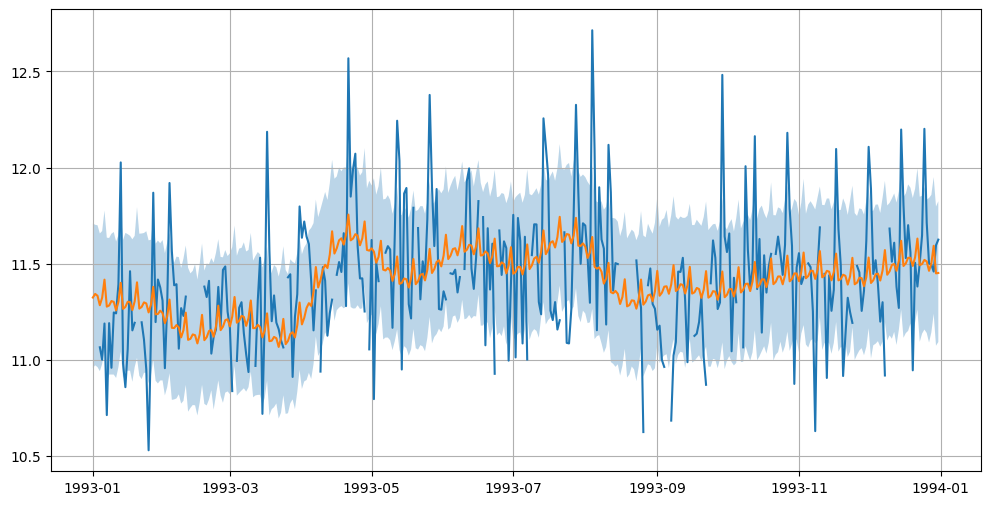

In [29]:
# テストデータの期間分だけ未来データを作成して予測する
test_periods = len(test)
future_test = m.make_future_dataframe(periods=test_periods, include_history=False)
forecast_test = m.predict(future_test)

# 結果の表示（上位5行）
display(forecast_test[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(3))

plt.figure(figsize=(12,6))
plt.plot(test['ds'], test['y'], label='Actual')
plt.plot(forecast_test['ds'], forecast_test['yhat'], label='Forecast')
plt.fill_between(forecast_test['ds'], forecast_test['yhat_lower'], forecast_test['yhat_upper'], alpha=0.3, label='Uncertainty interval')
plt.grid()
plt.show()

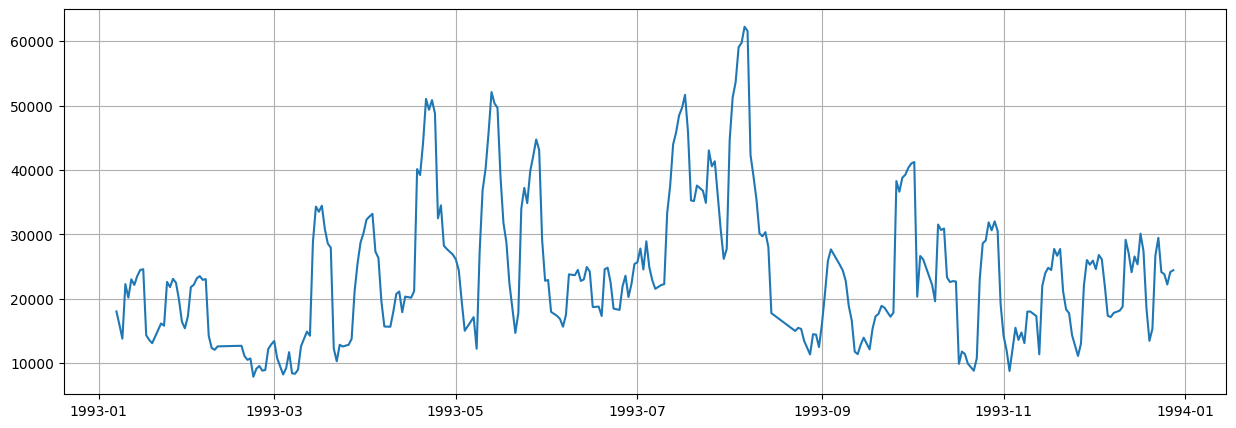

MAE (元スケール): 24336.592865080773


In [28]:
eval_df = pd.DataFrame({
    'ds': test['ds'].values,
    'y_true': test['y'].values,
    'y_pred': forecast_test['yhat'].values
})

# NaN-> 除外
eval_df_clean = eval_df.dropna(subset=['y_true', 'y_pred'])

# exp()で元スケールにする
eval_df_clean['y_true_exp'] = np.exp(eval_df_clean['y_true'])
eval_df_clean['y_pred_exp'] = np.exp(eval_df_clean['y_pred'])
abs_errors = np.abs(eval_df_clean['y_true_exp'] - eval_df_clean['y_pred_exp'])


# 移動平均を計算して滑らかな折れ線を描画
window_size = 7  # 7日間移動平均
abs_errors_ma = abs_errors.rolling(window=window_size, center=True).mean()

plt.figure(figsize=(15,5))
plt.plot(eval_df_clean['ds'], abs_errors_ma)
plt.grid()
plt.show()

# MAE計算
mae = mean_absolute_error(eval_df_clean['y_true_exp'], eval_df_clean['y_pred_exp'])
print('MAE (元スケール):', mae)
